<center><H1>EE 679: Computing Assignment 1</H1>
<H2> Name: Vinit Awale</H2>
<H2> Roll No: 18D070067 </H2>
<H2> Date: 2/10/2020</H2>
</center>

<b><i><H3> Question 1:</H3></i></b>
 Given the following specification for a single-formant resonator, obtain the transfer function of the filter H(z) from the relation between resonance frequency / bandwidth, and the pole angle / radius.  Plot filter magnitude response (dB magnitude versus frequency) and impulse response.
 
  
<b> F1 (formant) = 900 Hz   </b>     
<b> B1(bandwidth) = 200 Hz    </b>     
<b> Fs (sampling freq) = 16 kHz   </b>    

In [50]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

Bi, Fi, Fs = sp.symbols('Bi Fi Fs', real = True)  # define symbols for the input parameters

T = 1/Fs                            # define the period of the input signal

# We can find the magnitude and angle of the ploes of the transfer function from Bi and Fi
ri = sp.exp(-sp.pi*Bi*Fi)           # Magnitude of the pole corresponding to the ith formant
theta = 2*sp.pi*Bi*T                # Angle of the pole corresponding to the ith formant

z = sp.Symbol('z',real = True)                   # define a symbol for the complex variable z 

H = 1/(1-2*ri*sp.cos(theta)*z**-1 + (ri**2)*(z**-2))        # define the transfer function
H

1/(1 - 2*exp(-pi*Bi*Fi)*cos(2*pi*Bi/Fs)/z + exp(-2*pi*Bi*Fi)/z**2)

In [51]:
# Now we find the transfer function in terms of normalized frequency omega

omega = sp.Symbol('omega', real = True)
H = H.subs(z,sp.exp(sp.I*omega*T))
H

1/(1 - 2*exp(-I*omega/Fs)*exp(-pi*Bi*Fi)*cos(2*pi*Bi/Fs) + exp(-2*I*omega/Fs)*exp(-2*pi*Bi*Fi))

In [52]:
# Calculate the transfer function for our given input formant frequencies
H = H.subs({Fi:900, Bi:200, Fs:16000})
H

1/(1 + exp(-360000*pi)*exp(-I*omega/8000) - 2*((-1/4 + sqrt(5)/4)*sqrt(1/2 - sqrt(2)/4) + sqrt(sqrt(2)/4 + 1/2)*sqrt(sqrt(5)/8 + 5/8))*exp(-180000*pi)*exp(-I*omega/16000))

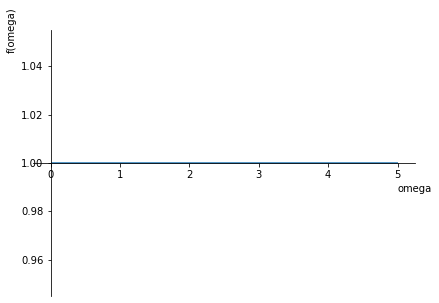

In [55]:
from sympy.plotting import plot

plot(H, (omega, 0, 5))

In [54]:
H = sp.Abs(H)

In [56]:
H

sqrt(1/(sqrt(1/2 - sqrt(2)/4)*exp(-540000*pi)*exp(I*omega/16000)/2 + sqrt(1/2 - sqrt(2)/4)*exp(-180000*pi)*exp(I*omega/16000)/2 - 2*sqrt(sqrt(2)/4 + 1/2)*sqrt(sqrt(5)/8 + 5/8)*exp(-540000*pi)*exp(I*omega/16000) - 2*sqrt(sqrt(2)/4 + 1/2)*sqrt(sqrt(5)/8 + 5/8)*exp(-180000*pi)*exp(I*omega/16000) - sqrt(5)*sqrt(1/2 - sqrt(2)/4)*exp(-540000*pi)*exp(I*omega/16000)/2 - sqrt(5)*sqrt(1/2 - sqrt(2)/4)*exp(-180000*pi)*exp(I*omega/16000)/2 + exp(-360000*pi)*exp(I*omega/8000) + 2*exp(-360000*pi) + sqrt(2)*exp(-360000*pi)/4 + sqrt(10)*exp(-360000*pi)/4 - 2*sqrt(1/2 - sqrt(2)/4)*sqrt(sqrt(2)/4 + 1/2)*sqrt(sqrt(5)/8 + 5/8)*exp(-360000*pi) + 2*sqrt(5)*sqrt(1/2 - sqrt(2)/4)*sqrt(sqrt(2)/4 + 1/2)*sqrt(sqrt(5)/8 + 5/8)*exp(-360000*pi) + exp(-720000*pi) + 1 + exp(-360000*pi)*exp(-I*omega/8000) + sqrt(1/2 - sqrt(2)/4)*exp(-540000*pi)*exp(-I*omega/16000)/2 + sqrt(1/2 - sqrt(2)/4)*exp(-180000*pi)*exp(-I*omega/16000)/2 - 2*sqrt(sqrt(2)/4 + 1/2)*sqrt(sqrt(5)/8 + 5/8)*exp(-540000*pi)*exp(-I*omega/16000) - 2*sqrt

In [4]:
impulse_response = find_impulse_response(random_signal, freq, bandwidth)

<ipython-input-3-ec393afda4c1>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  h[i] = np.exp(-1j * 2 * np.pi * freq * i / bandwidth) * tf[i]


(400.0, 600.0)

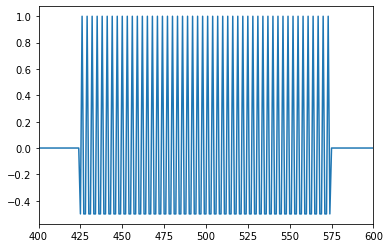

In [6]:
plt.plot(impulse_response)
plt.xlim(400, 600)

In [3]:
# Find impulse response from a given Tranfer Function
def find_impulse_response(tf, freq, bandwidth):
    """
    Find the impulse response from a transfer function
    :param tf: Transfer Function
    :param freq: Frequency of the impulse response
    :param bandwidth: Bandwidth of the impulse response
    :return: Impulse response
    """
    # Find the impulse response
    h = np.zeros(len(tf))
    for i in range(len(tf)):
        h[i] = np.exp(-1j * 2 * np.pi * freq * i / bandwidth) * tf[i]
    return h


In [ ]:
# Find impulse response from a given Tranfer Function

def get_impulse_response(freq, bandwidth):
    """
    Find the impulse response from a transfer function
    :param tf: Transfer Function
    :param freq: Frequency of the impulse response
    :param bandwidth: Bandwidth of the impulse response
    :return: Impulse response
    """
    # Find the impulse response
    h = np.zeros(len(tf))
    for i in range(len(tf)):
        h[i] = np.exp(-1j * 2 * np.pi * freq * i / bandwidth) * tf[i]
    return h